Black-Scholes equation:
$$\frac{\partial V}{\partial t}+\frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2}+rS\frac{\partial V}{\partial S}-rV=0$$
where
- $t$ is a time in years
- $r$ is the annualized risk-free interest rate, continuously compunded, i.e., the force of interest
- $S(t)$ is the price of the underlying asset at time $t$
- $\sigma$ is the standard deviation of the stock's returns
- $V$ is the price of the option

Boundary conditions:
$$\begin{align*}
C(0,t) &= 0 \text{ for all } t\\
C(S,t) &\to S-K \text{ as } S\to\infty\\
C(S,T) &= \max\{S-K,0\}
\end{align*}$$
where
- $C$ is the price of a European call option
- $T$ is the time of option expiration
- $\tau=T-t$ is the time until maturity
- $K$ is the strike price of the option

Solution:
$$\begin{align*}
C(F,\tau) &= D[N(d_+)F - N(d_-)K]\\
d_+ &= \frac{1}{\sigma\sqrt{\tau}}\left[\ln\left(\frac{F}{K}\right)+\frac{1}{2}\sigma^2\tau\right]\\
d_- &= d_+ - \sigma\sqrt{\tau}
\end{align*}$$
where
- $N(x)$ is the standard normal CDF
- $D=\exp(-r\tau)$ is the discount factor
- $F=\exp(r\tau)S=S/D$ is the forward price of the underlying asset

Given put-call parity, $C-P = D(F-K) = S-DK$, the price of a European put option $P$ is
$$P(P(F,\tau)) = D[N(-d_-)K - N(-d_+)F]$$

In [3]:
import numpy as np
from scipy.special import ndtr
import matplotlib.pyplot as plt

In [4]:
from scipy.optimize import root_scalar

In [5]:
def call_put_price(
    t, r,
    S, sigma,
    T, K,
):
    tau = T - t
    D = np.exp(-r * tau)
    F = S / D
    d_plus = (np.log(F / K) + 0.5 * sigma**2 * tau) / sigma * np.sqrt(tau)
    d_minus = d_plus - sigma * np.sqrt(tau)
    C = D * (ndtr(d_plus) * F - ndtr(d_minus) * K)
    P = D * (ndtr(-d_minus) * K - ndtr(-d_plus) * F)
    return C, P

In [2]:
def call_pnl(K, S, C):
    return np.maximum(S-K, 0) - C

def put_pnl(K, S, P):
    return np.maximum(K-S, 0) - P

In [6]:
asset_prices = np.linspace(0.5, 1.5, 200)
times = np.linspace(0., 2., 200)

In [7]:
call_prices = np.empty((asset_prices.size, times.size))
put_prices = np.empty((asset_prices.size, times.size))
for i in range(asset_prices.size):
    for j in range(times.size):
        call_prices[i,j], put_prices[i,j] = call_put_price(
            t=times[j], r=0.04,
            S=asset_prices[i], sigma=0.2,
            T=2., K=1.,
        )
call_prices.shape, put_prices.shape

((200, 200), (200, 200))

In [8]:
def asset_price_for_0C(t):
    def f(S, t):
        return call_put_price(
            t=t, r=0.04,
            S=S, sigma=0.2,
            T=2., K=1.,
        )[0]
    res = root_scalar(f, args=t, x0=1.)
    return res.root

def asset_price_for_0P(t):
    def f(S, t):
        return call_put_price(
            t=t, r=0.04,
            S=S, sigma=0.2,
            T=2., K=1.,
        )[1]
    res = root_scalar(f, args=t, x0=1.)
    return res.root

# def time_for_0Cpnl(S):
#     def f(t):
#         return call_put_pnl(
#             t=t, r=0.04,
#             S=S, sigma=0.2,
#             T=2., K=1.,
#         )[0]
#     res = root_scalar(f, x0=1.)
#     return res.root

# def time_for_0Ppnl(S):
#     def f(t):
#         return call_put_pnl(
#             t=t, r=0.04,
#             S=S, sigma=0.2,
#             T=2., K=1.,
#         )[1]
#     res = root_scalar(f, x0=1.)
#     return res.root

In [9]:
asset_prices_for_0C = np.empty_like(times)
for i in range(times.size):
    asset_prices_for_0C[i] = asset_price_for_0C(times[i])

asset_prices_for_0P = np.empty_like(times)
for i in range(times.size):
    asset_prices_for_0P[i] = asset_price_for_0P(times[i])

In [10]:
np.min(call_prices), np.max(call_prices), np.min(put_prices), np.max(put_prices)

(np.float64(-0.25),
 np.float64(0.577007382557906),
 np.float64(-0.25),
 np.float64(0.4805587023945103))

In [23]:
call_put_prices_grid = np.linspace(0., 0.6, 200)

In [24]:
call_pnls = np.empty((asset_prices.size, call_put_prices_grid.size))
put_pnls = np.empty((asset_prices.size, call_put_prices_grid.size))
for i in range(asset_prices.size):
    for j in range(call_put_prices_grid.size):
        call_pnls[i,j] = call_pnl(K=1., S=asset_prices[i], C=call_put_prices_grid[j])
        put_pnls[i,j] = put_pnl(K=1., S=asset_prices[i], P=call_put_prices_grid[j])
call_pnls.shape, put_pnls.shape

((200, 200), (200, 200))

In [25]:
np.min(call_pnls), np.max(call_pnls), np.min(put_pnls), np.max(put_pnls)

(np.float64(-0.6), np.float64(0.5), np.float64(-0.6), np.float64(0.5))

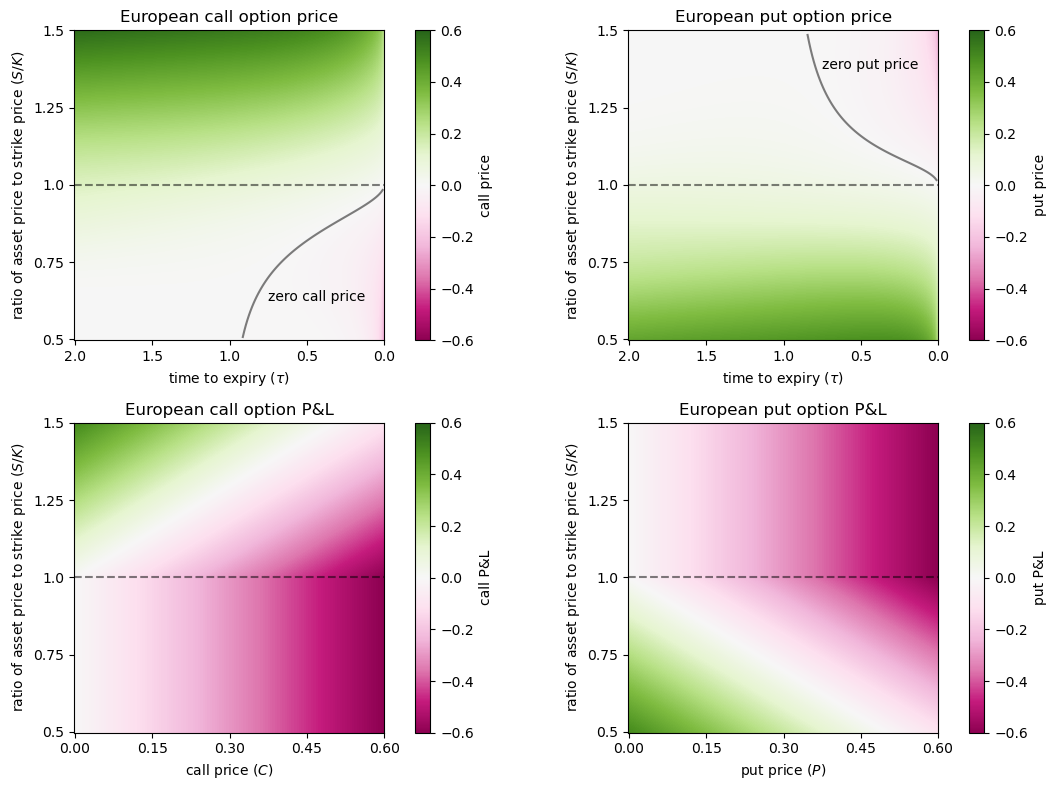

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(6*2, 4*2), layout='tight')

im = ax[0,0].imshow(call_prices, cmap='PiYG', vmin=-0.6, vmax=0.6, origin='lower')
ax[0,0].axhline(100, c='k', ls='--', alpha=0.5)
x = 100*times[:-1]
y = 200*(asset_prices_for_0C-0.5)[:-1]
ax[0,0].plot(x[y>0], y[y>0], c='k', alpha=0.5)
ax[0,0].text(125, 25, 'zero call price')
ax[0,0].set_xticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(2, 0-0.5, -0.5))
ax[0,0].set_yticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(0.5, 1.5+0.25, 0.25))
ax[0,0].set_xlabel('time to expiry '+r'$(\tau)$')
ax[0,0].set_ylabel('ratio of asset price to strike price '+r'$(S/K)$')
plt.colorbar(im, label='call price')
ax[0,0].set_title('European call option price')

im = ax[0,1].imshow(put_prices, cmap='PiYG', vmin=-0.6, vmax=0.6, origin='lower')
ax[0,1].axhline(100, c='k', ls='--', alpha=0.5)
x = 100*times[:-1]
y = 200*(asset_prices_for_0P-0.5)[:-1]
ax[0,1].plot(x[y<200], y[y<200], c='k', alpha=0.5)
ax[0,1].text(125, 175, 'zero put price')
ax[0,1].set_xticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(2, 0-0.5, -0.5))
ax[0,1].set_yticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(0.5, 1.5+0.25, 0.25))
ax[0,1].set_xlabel('time to expiry '+r'$(\tau)$')
ax[0,1].set_ylabel('ratio of asset price to strike price '+r'$(S/K)$')
plt.colorbar(im, label='put price')
ax[0,1].set_title('European put option price')

im = ax[1,0].imshow(call_pnls, cmap='PiYG', vmin=-0.6, vmax=0.6, origin='lower')
ax[1,0].axhline(100, c='k', ls='--', alpha=0.5)
# x = 100*times_for_0Cpnl[:-1]
# y = 200*(asset_prices-0.5)[:-1]
# ax[1,0].plot(x, y, c='k', alpha=0.5)
# ax[1,0].text(125, 25, 'zero call PnL')
ax[1,0].set_xticks(ticks=np.arange(0, 200+50, 50), labels=[f'{i:.2f}' for i in np.arange(0., 0.6+0.15, 0.15)])
ax[1,0].set_yticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(0.5, 1.5+0.25, 0.25))
ax[1,0].set_xlabel('call price '+r'$(C)$')
ax[1,0].set_ylabel('ratio of asset price to strike price '+r'$(S/K)$')
plt.colorbar(im, label='call P&L')
ax[1,0].set_title('European call option P&L')

im = ax[1,1].imshow(put_pnls, cmap='PiYG', vmin=-0.6, vmax=0.6, origin='lower')
ax[1,1].axhline(100, c='k', ls='--', alpha=0.5)
# x = 100*times_for_0Ppnl[:-1]
# y = 200*(asset_prices-0.5)[:-1]
# x = np.where(x<0, np.nan, x)
# ax[1,1].plot(x, y, c='k', alpha=0.5)
# ax[1,1].text(125, 175, 'zero put PnL')
ax[1,1].set_xticks(ticks=np.arange(0, 200+50, 50), labels=[f'{i:.2f}' for i in np.arange(0., 0.6+0.15, 0.15)])
ax[1,1].set_yticks(ticks=np.arange(0, 200+50, 50), labels=np.arange(0.5, 1.5+0.25, 0.25))
ax[1,1].set_xlabel('put price '+r'$(P)$')
ax[1,1].set_ylabel('ratio of asset price to strike price '+r'$(S/K)$')
plt.colorbar(im, label='put P&L')
ax[1,1].set_title('European put option P&L');